In [ ]:
#import libraries
import torch                                              #import pytorch library
from torch.utils.data import DataLoader, Dataset          #Efficient batch processing
from torchvision import datasets, transforms              #Dataset loading and preprocessing

In [ ]:
#Define transforms
transform_train = transforms.Compose([
    transforms.Resize((256)),  #resizes every image so its shorter side becomes 256 pixels
    transforms.CenterCrop(224),#crops a 224×224 pixel square from the center of the image.
    transforms.ToTensor(),     #changes pixel values from range 0–255 to 0–1, making them ready for model input.
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
                          ])

transform_test = transforms.Compose([
    transforms.Resize((256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
                          ])

In [ ]:
from PIL import Image
import numpy as np

class CarClassifier(Dataset):
    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

       #resize to (28,28)
       image = self.features[idx].reshape(28,28)

       #change datatype to np.uint8
       image = image.astype(np.uint8)

       #convert array to PIL image
       image = Image.fromarray(image)

       #apply transforms
       image = self.transform(image)

       #get label
       label = torch.tensor(self.labels[idx],dtype=torch.long)

       return image, label



In [ ]:
#Load train and test datasets
train_dir = "/content/drive/MyDrive/cars_classifier/data/train"
test_dir = "/content/drive/MyDrive/cars_classifier/data/test"

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

In [ ]:
#Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=10,num_workers=5, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False,pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
#Verify classes inside folder
print(train_dataset.classes)
print(train_dataset.class_to_idx)

['swift', 'wagonr']
{'swift': 0, 'wagonr': 1}


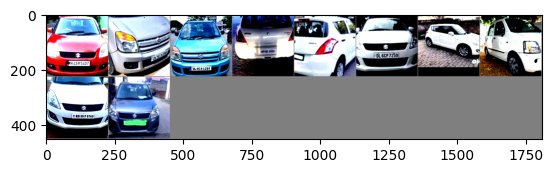

Labels: ['swift', 'wagonr', 'wagonr', 'swift', 'swift', 'swift', 'swift', 'wagonr', 'swift', 'wagonr']


In [ ]:
#Visulaize the images
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5   #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels:', [train_dataset.classes[i] for i in labels])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#fetch the pretrained model
import torchvision.models as models

densenet121 = models.densenet121(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 170MB/s]


In [ ]:
print(densenet121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
densenet121.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
# Freeze all feature extraction layers
for param in densenet121.features.parameters():
  param.requires_grad = False

In [ ]:
# DenseNet121 has 1024 features from the last layer
densenet121.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)

In [ ]:
print(densenet121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet121 = densenet121.to(device)
print(densenet121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
learning_rate = 0.0001
epochs = 100
criteria = nn.CrossEntropyLoss()
optimizer= optim.Adam(densenet121.classifier.parameters(), lr=learning_rate)

In [ ]:
# Add this before training
print(f"Using device: {device}")
print(f"Model is on: {next(densenet121.parameters()).device}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using device: cuda
Model is on: cuda:0
CUDA available: True


In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False  # Don't stop
        else:
            self.counter += 1
            return self.counter >= self.patience  # Stop if patience exceeded

# Usage in training loop:
early_stopping = EarlyStopping(patience=5)

#training loop
for epoch in range(epochs):
  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = densenet121(batch_features)

    # calculate loss
    loss = criteria(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


  if early_stopping(avg_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch: 1 , Loss: 0.6107934155811866
Epoch: 2 , Loss: 0.3693944513487319
Epoch: 3 , Loss: 0.2926696492048601
Epoch: 4 , Loss: 0.26199739121366294
Epoch: 5 , Loss: 0.23582985313454022
Epoch: 6 , Loss: 0.23299763322186967
Epoch: 7 , Loss: 0.22118071863272537
Epoch: 8 , Loss: 0.21222145477465043
Epoch: 9 , Loss: 0.20938910331266622
Epoch: 10 , Loss: 0.20650628841443297
Epoch: 11 , Loss: 0.21581937471249452
Epoch: 12 , Loss: 0.18320503317130107
Epoch: 13 , Loss: 0.1842549830597515
Epoch: 14 , Loss: 0.1862974433771645
Epoch: 15 , Loss: 0.20014704211692635
Epoch: 16 , Loss: 0.1854571796177576
Epoch: 17 , Loss: 0.15575341889828753
Epoch: 18 , Loss: 0.1666934559548584
Epoch: 19 , Loss: 0.15542390628252178
Epoch: 20 , Loss: 0.1450142143565851
Epoch: 21 , Loss: 0.1563859114598017
Epoch: 22 , Loss: 0.14046824992401524
Epoch: 23 , Loss: 0.15509614598801516
Epoch: 24 , Loss: 0.14117872472755455
Epoch: 25 , Loss: 0.1565780415063879
Epoch: 26 , Loss: 0.14065041674184614
Epoch: 27 , Loss: 0.13309435738

In [ ]:
densenet121.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
from sklearn.metrics import precision_score, recall_score
import torch

# Evaluation on test data
densenet121.eval()  # Set model to evaluation mode
total = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        # Move data to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = densenet121(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

        # Collect predictions and labels as tensors on GPU
        all_preds.append(predicted)
        all_labels.append(batch_labels)

# Concatenate tensors on GPU
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to NumPy only once for scikit-learn
all_preds_np = all_preds.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

# Calculate metrics
accuracy = correct / total
precision = precision_score(all_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_labels_np, all_preds_np, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 0.9979
Precision: 0.9979
Recall: 0.9979


In [ ]:
# Evaluation on test data
densenet121.eval()  # Set model to evaluation mode
total = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # Move data to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = densenet121(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

        # Collect predictions and labels as tensors on GPU
        all_preds.append(predicted)
        all_labels.append(batch_labels)

# Concatenate tensors on GPU
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to NumPy only once for scikit-learn
all_preds_np = all_preds.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

# Calculate metrics
accuracy = correct / total
precision = precision_score(all_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_labels_np, all_preds_np, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9575
Precision: 0.9576
Recall: 0.9575


In [ ]:
import pickle

# Save the trained pipeline using pickle
pickle_model_path = "model.pkl"
with open(pickle_model_path, "wb") as f:
    pickle.dump(densenet121, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
